In [1]:
import sys
sys.path.append('..')

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.timescale_connector import TimescaleConnector


In [2]:
symbol_lts = TimescaleConnector.get_symbols()

df_ = {}
for symbol in symbol_lts:
    df_[symbol] = TimescaleConnector.query_ohlcv_daily(symbol)

In [3]:
# Prices prior to 2023 as a training set and the rest as test set
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

df_new = {}
for stock in symbol_lts:
    df_new[stock] = {}
    df_new[stock]["Train"], df_new[stock]["Test"] = split(df_[stock], "2023", "close")

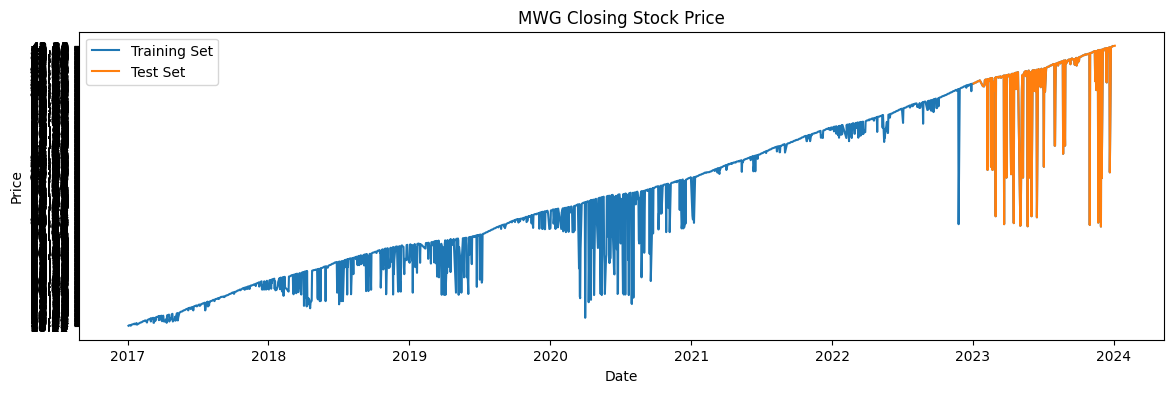

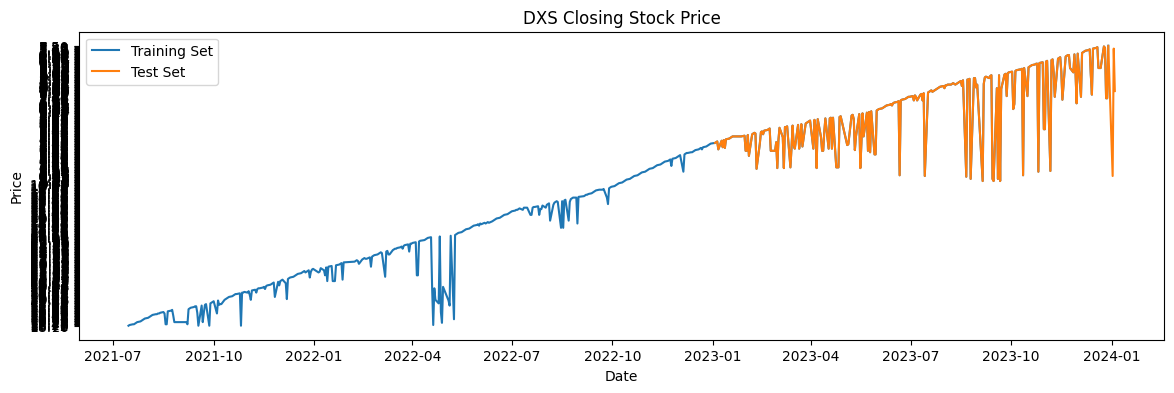

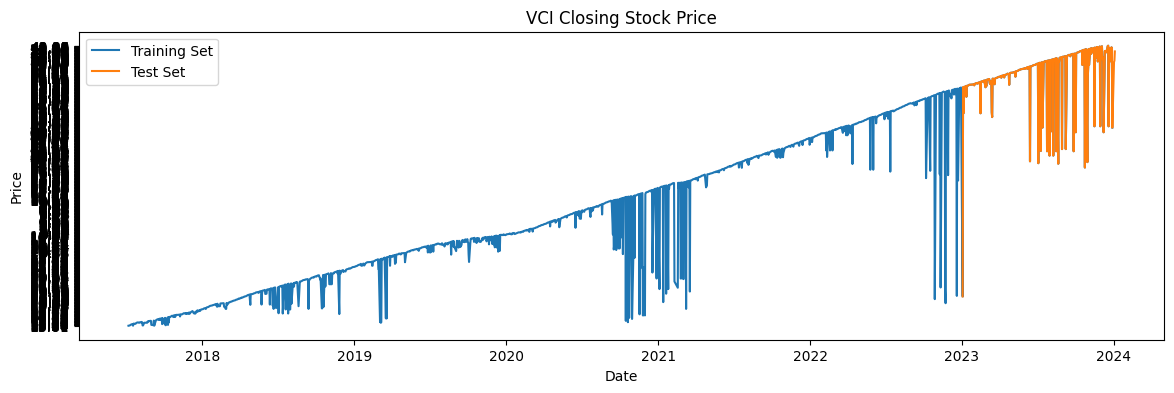

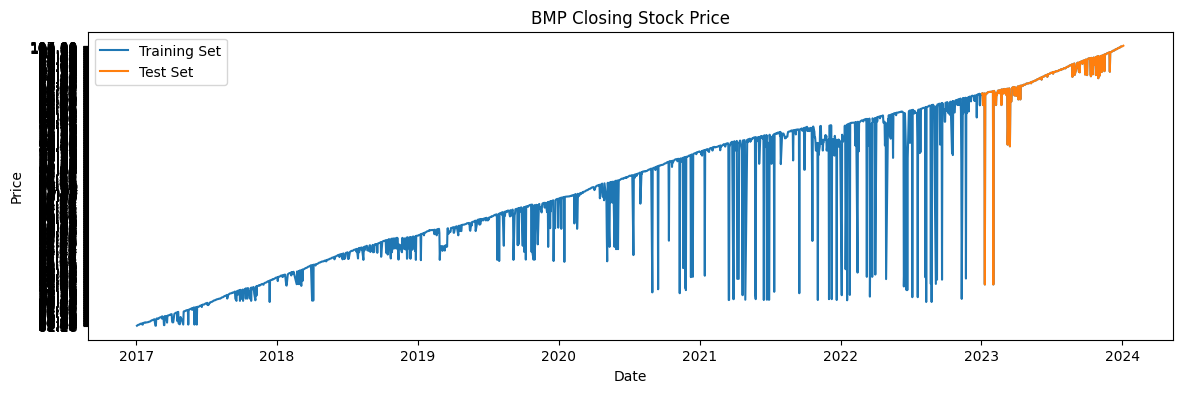

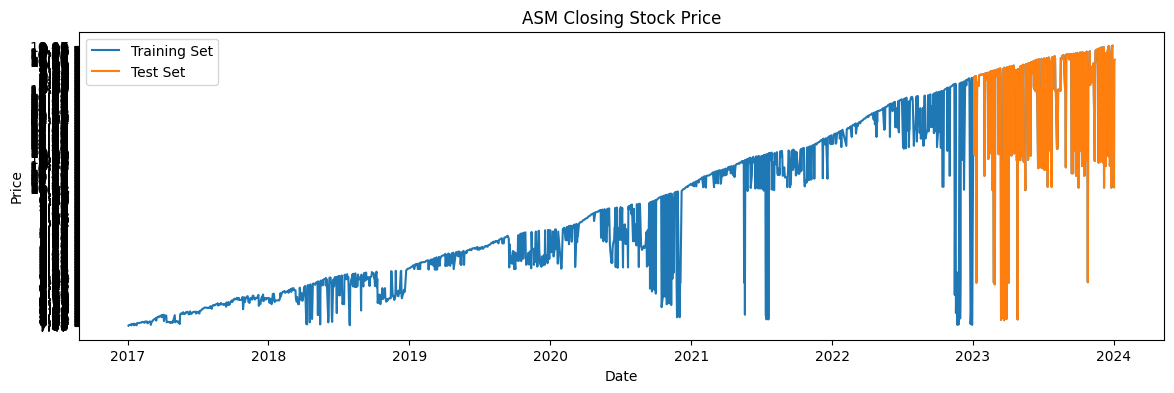

In [4]:
for i in symbol_lts[:5]:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing Stock Price")

In [5]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(symbol_lts):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [6]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

MWG (1748, 1)
DXS (615, 1)
VCI (1621, 1)
BMP (1748, 1)
ASM (1748, 1)
SAM (1748, 1)
HPG (1748, 1)
FTS (1740, 1)
FPT (1748, 1)
NT2 (1748, 1)
VCB (1746, 1)
VPB (1593, 1)
DPM (1748, 1)
DIG (1748, 1)
MSB (755, 1)
CII (1748, 1)
DBC (1744, 1)
AAA (1748, 1)
SSI (1748, 1)
NKG (1748, 1)
BID (1748, 1)
HT1 (1746, 1)
MBB (1748, 1)
KOS (1510, 1)
HCM (1748, 1)
STB (1748, 1)
DXG (1748, 1)
VND (1736, 1)
SZC (1241, 1)
AGG (995, 1)
PAN (1739, 1)
TPB (1426, 1)
KBC (1748, 1)
IMP (1732, 1)
HDB (1495, 1)
EIB (1748, 1)
VIB (1735, 1)
VNM (1746, 1)
HDG (1748, 1)
SAB (1748, 1)
MSN (1748, 1)
BCG (1748, 1)
SCS (1612, 1)
KDC (1748, 1)
VIC (1746, 1)
VHC (1746, 1)
PDR (1748, 1)
POW (1449, 1)
VCG (1745, 1)
PTB (1747, 1)
KDH (1748, 1)
OCB (730, 1)
PVD (1748, 1)
CMG (1744, 1)
CTD (1748, 1)
VGC (1743, 1)
ACB (1745, 1)
TCB (1399, 1)
PLX (1676, 1)
GEX (1745, 1)
GEG (1657, 1)
DCM (1748, 1)
VJC (1711, 1)
HHV (840, 1)
SBT (1748, 1)
VPI (1516, 1)
TMS (1678, 1)
SJS (1748, 1)
DGW (1748, 1)
CRE (1333, 1)
LPB (1551, 1)
PHR (1748, 

In [7]:
# Check the average length of the training set
length = []
for i in transform_train.keys():
    length.append(transform_train[i].shape[0])
print("Average length of the training set: ", np.mean(length))

Average length of the training set:  1634.8


In [8]:
keys_to_delete = []
for i in transform_train.keys():
    if transform_train[i].shape[0] < 1400:
        keys_to_delete.append(i)

for key in keys_to_delete:
    del transform_train[key]
    del transform_test[key]
    del scaler[key]


In [9]:
#Check the length of the training set
len(transform_train)

91

In [10]:
# Create a new symbol list from the training set
symbol_lst_filtered = []
for i in transform_train.keys():
    symbol_lst_filtered.append(i)

In [11]:
# Split the training set into train and validation set
# Define the lookback period

lookback = 60

trainset = {}
testset = {}
for j in symbol_lst_filtered:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(lookback, 1400): # 1400 is about the average length of the training set, this filter out the stocks that are too short, in this case there are 90 stocks left
        X_train.append(transform_train[j][i - lookback : i, 0])
        y_train.append(transform_train[j][i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    trainset[j]["y"] = y_train

    testset[j] = {}
    X_test = []
    y_test = []
    for i in range(60, 226):
        X_test.append(transform_test[j][i - lookback : i, 0])
        y_test.append(transform_test[j][i, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [12]:
# CHeck the training set again before training
arr_buff = []
for i in symbol_lst_filtered:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=symbol_lst_filtered)

,X_train,y_train,X_test,y_test
MWG,"(1340, 60, 1)","(1340,)","(166, 60, 1)","(166,)"
VCI,"(1340, 60, 1)","(1340,)","(166, 60, 1)","(166,)"
BMP,"(1340, 60, 1)","(1340,)","(166, 60, 1)","(166,)"
ASM,"(1340, 60, 1)","(1340,)","(166, 60, 1)","(166,)"
SAM,"(1340, 60, 1)","(1340,)","(166, 60, 1)","(166,)"
...,...,...,...,...
DHC,"(1340, 60, 1)","(1340,)","(166, 60, 1)","(166,)"
ANV,"(1340, 60, 1)","(1340,)","(166, 60, 1)","(166,)"
NLG,"(1340, 60, 1)","(1340,)","(166, 60, 1)","(166,)"
GAS,"(1340, 60, 1)","(1340,)","(166, 60, 1)","(166,)"


In [13]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
X_test.shape

(166, 60)

In [15]:
# Transform numpy arrays to tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [16]:
for i in symbol_lst_filtered:
    print("Fitting to", i)
    print(trainset[i]["X"], trainset[i]["y"])

Fitting to MWG
[[[0.        ]
  [0.00115512]
  [0.00214521]
  ...
  [0.02260726]
  [0.02227723]
  [0.02062706]]

 [[0.00115512]
  [0.00214521]
  [0.00214521]
  ...
  [0.02227723]
  [0.02062706]
  [0.01881188]]

 [[0.00214521]
  [0.00214521]
  [0.        ]
  ...
  [0.02062706]
  [0.01881188]
  [0.01980198]]

 ...

 [[0.76782178]
  [0.78333333]
  [0.77920792]
  ...
  [0.72409241]
  [0.72409241]
  [0.72739274]]

 [[0.78333333]
  [0.77920792]
  [0.78729373]
  ...
  [0.72409241]
  [0.72739274]
  [0.7339934 ]]

 [[0.77920792]
  [0.78729373]
  [0.76138614]
  ...
  [0.72739274]
  [0.7339934 ]
  [0.73894389]]] [0.01881188 0.01980198 0.01980198 ... 0.7339934  0.73894389 0.7290429 ]
Fitting to VCI
[[[0.15762996]
  [0.16825042]
  [0.16359232]
  ...
  [0.16098379]
  [0.16321968]
  [0.1665735 ]]

 [[0.16825042]
  [0.16359232]
  [0.16452394]
  ...
  [0.16321968]
  [0.1665735 ]
  [0.16023849]]

 [[0.16359232]
  [0.16452394]
  [0.16061114]
  ...
  [0.1665735 ]
  [0.16023849]
  [0.15986585]]

 ...

 [[0

In [17]:
# Create a DataLoader
# Assuming that data_dict is a dictionary where
# the key is the stock name and the value is a tuple of (features, labels)
from torch.utils.data import TensorDataset

train_loaders = {}

for stock in symbol_lst_filtered:
    # Convert numpy arrays to PyTorch tensors
    features_tensor = torch.tensor(trainset[i]["X"]).float()
    labels_tensor = torch.tensor(trainset[i]["y"]).float()

    # Create a TensorDataset from the tensors
    dataset = TensorDataset(features_tensor, labels_tensor)

    # Create a DataLoader from the TensorDataset
    train_loader = DataLoader(dataset, batch_size=200, shuffle=True)

    # Add the DataLoader to the dictionary
    train_loaders[stock] = train_loader

In [18]:
# Create test sets
test_loaders = {}

for stock in symbol_lst_filtered:
    # Convert numpy arrays to PyTorch tensors
    features_tensor = torch.tensor(testset[i]["X"]).float()
    labels_tensor = torch.tensor(testset[i]["y"]).float()

    # Create a TensorDataset from the tensors
    dataset = TensorDataset(features_tensor, labels_tensor)

    # Create a DataLoader from the TensorDataset
    test_loader = DataLoader(dataset, batch_size=200, shuffle=True)

    # Add the DataLoader to the dictionary
    test_loaders[stock] = test_loader

In [19]:
# Check the shape of the of the input and target tensors
# for _, batch in enumerate(train_loader):
#     x_batch, y_batch = batch[0].to(device), batch[1].to(device)
#     print(x_batch.shape, y_batch.shape)
#     break

In [20]:
# Create a LSTM class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 6, 1)
model

LSTM(
  (lstm): LSTM(1, 6, batch_first=True)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)

In [21]:
def train_one_epoch():
    model.train(True)
    for i in symbol_lst_filtered:
        print("Fitting to", i)
        running_loss = 0.0
        for epoch in range(num_epochs):
            print(f"Epoch: {epoch + 1}")
            for batch_index, batch in enumerate(train_loaders[i]):
                x_batch, y_batch = batch[0], batch[1]

                output = model(x_batch).squeeze()
                loss = loss_function(output, y_batch)
                running_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if batch_index % 100 == 99:  # print every 100 batches
                    avg_loss_across_batches = running_loss / 100
                    print(
                        "Batch {0}, Loss: {1:.3f}".format(
                            batch_index + 1, avg_loss_across_batches
                        )
                    )
                    running_loss = 0.0
            print()


In [22]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    for stock in symbol_lst_filtered:
        for batch_index, batch in enumerate(test_loaders[stock]):
            x_batch, y_batch = batch[0], batch[1]

            with torch.no_grad():
                output = model(x_batch).squeeze()
                loss = loss_function(output, y_batch)
                running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loaders)

    print("Val Loss: {0:.3f}".format(avg_loss_across_batches))
    print("***************************************************")

In [23]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Fitting to MWG
Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5



Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Fitting to VCI
Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Fitting to BMP
Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Fitting to ASM
Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Fitting to SAM
Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Fitting to HPG
Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Fitting to FTS
Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Fitting to FPT
Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Fitting to NT2
Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4

Epoch: 5

Epoch: 6

Epoch: 7

Epoch: 8

Epoch: 9

Epoch: 10

Fitting to VCB
Epoch

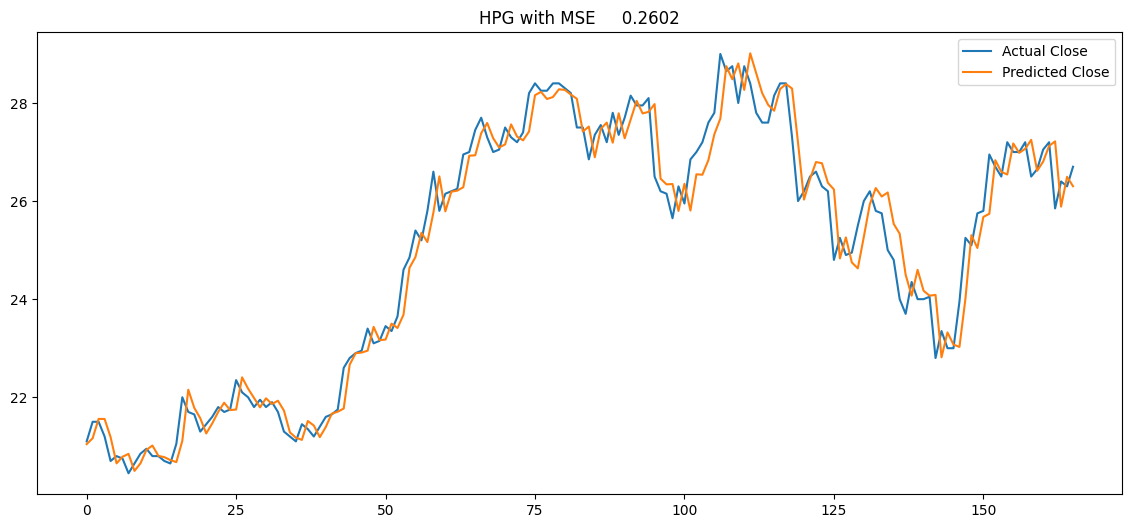

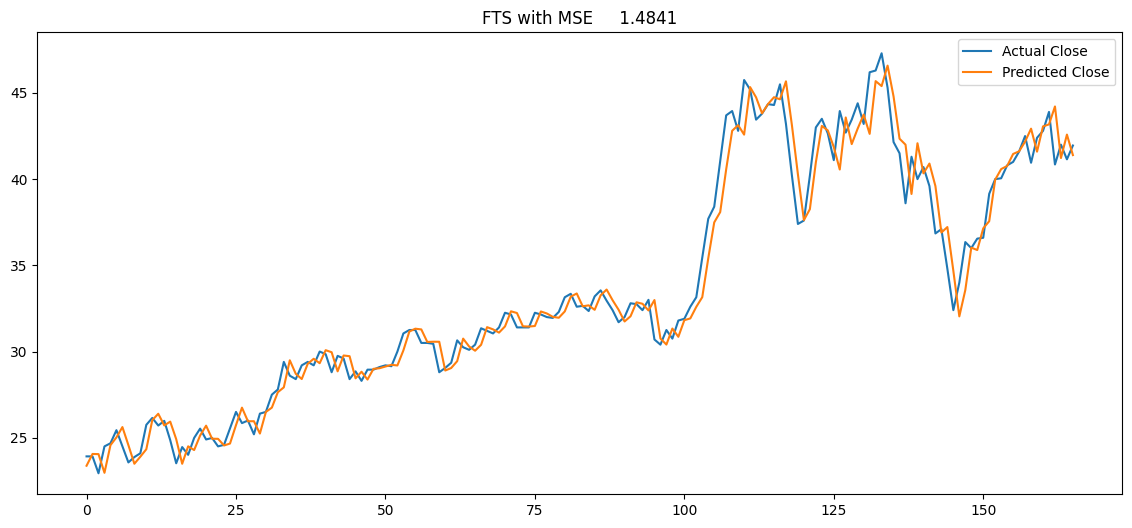

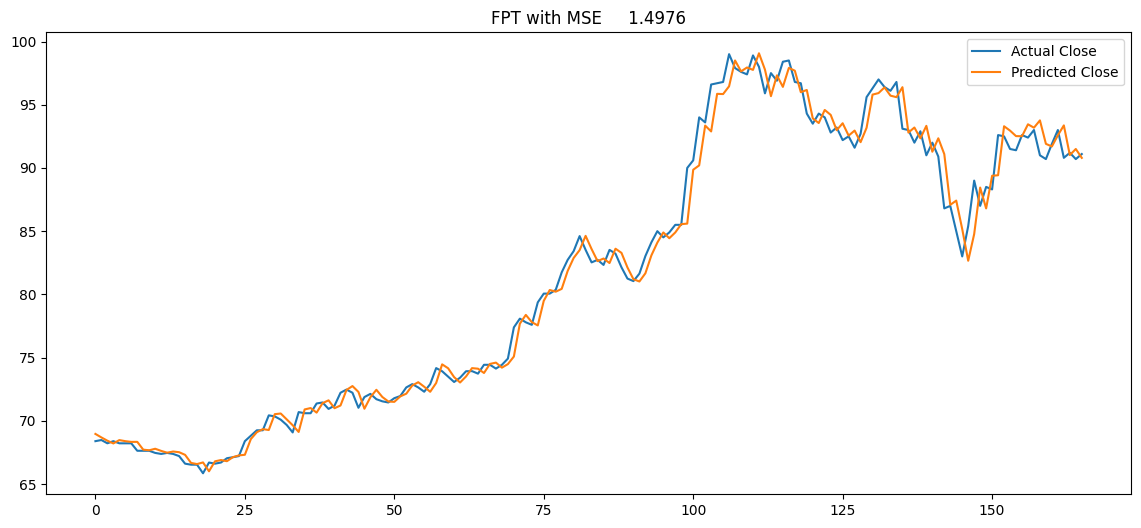

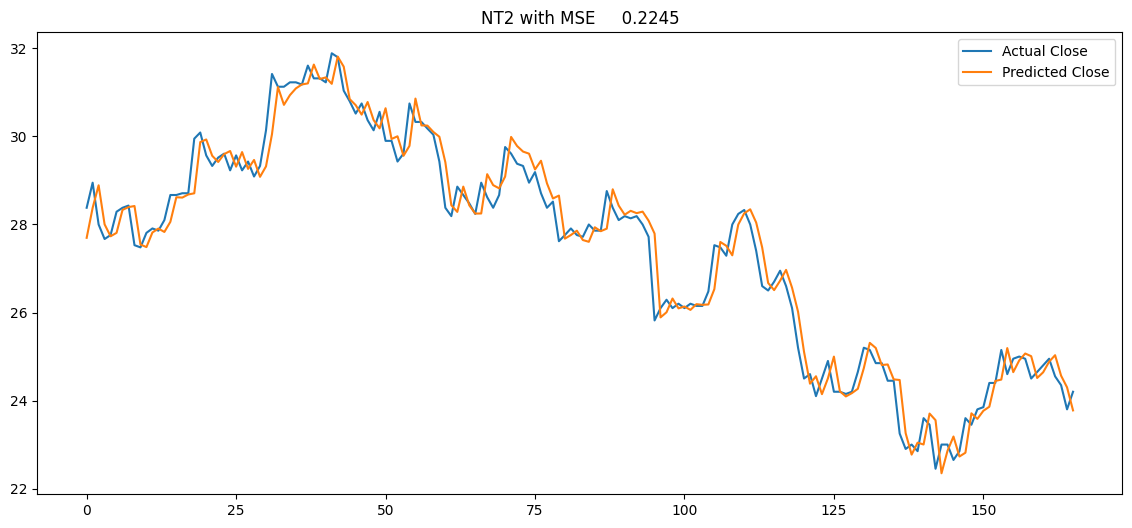

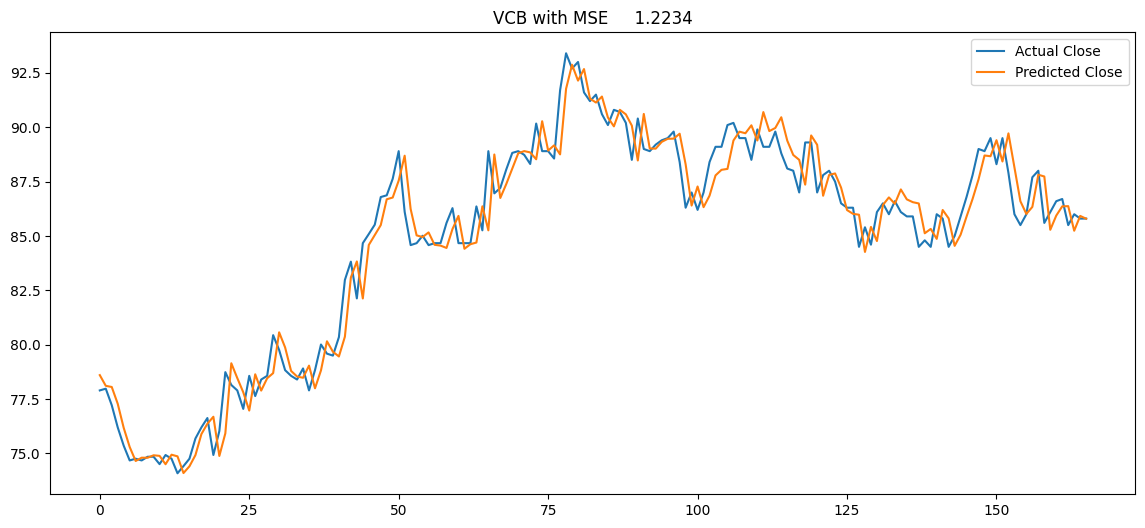

Average MSE:  0.9379451205561325


In [29]:
# Predict the test
from sklearn.metrics import mean_squared_error

pred_result = {}
MSEs = {}
for i in symbol_lst_filtered[5:10]:
    y_true = scaler[i].inverse_transform(
        torch.tensor(testset[i]["y"]).float().reshape(-1, 1)
    )
    y_pred = scaler[i].inverse_transform(model(torch.tensor(testset[i]["X"]).float()).detach().numpy())


    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    MSEs[i] = MSE
    plt.figure(figsize=(14, 6))
    plt.title("{} with MSE {:10.4f}".format(i, MSE))
    plt.plot(y_true, label="Actual Close")
    plt.plot(y_pred, label="Predicted Close")
    plt.legend()
    plt.show()

average_MSE = np.mean(list(MSEs.values()))
print("Average MSE: ", average_MSE)

In [30]:
symbol_lst_filtered

['MWG',
 'VCI',
 'BMP',
 'ASM',
 'SAM',
 'HPG',
 'FTS',
 'FPT',
 'NT2',
 'VCB',
 'VPB',
 'DPM',
 'DIG',
 'CII',
 'DBC',
 'AAA',
 'SSI',
 'NKG',
 'BID',
 'HT1',
 'MBB',
 'KOS',
 'HCM',
 'STB',
 'DXG',
 'VND',
 'PAN',
 'TPB',
 'KBC',
 'IMP',
 'HDB',
 'EIB',
 'VIB',
 'VNM',
 'HDG',
 'SAB',
 'MSN',
 'BCG',
 'SCS',
 'KDC',
 'VIC',
 'VHC',
 'PDR',
 'POW',
 'VCG',
 'PTB',
 'KDH',
 'PVD',
 'CMG',
 'CTD',
 'VGC',
 'ACB',
 'PLX',
 'GEX',
 'GEG',
 'DCM',
 'VJC',
 'SBT',
 'VPI',
 'TMS',
 'SJS',
 'DGW',
 'LPB',
 'PHR',
 'VHM',
 'CTR',
 'SHB',
 'REE',
 'GMD',
 'VSH',
 'GVR',
 'PPC',
 'HDC',
 'HSG',
 'VRE',
 'PC1',
 'CTG',
 'FRT',
 'BWE',
 'BCM',
 'PVT',
 'TCH',
 'DGC',
 'VIX',
 'BVH',
 'HAG',
 'DHC',
 'ANV',
 'NLG',
 'GAS',
 'PNJ']

In [ ]:
# Inverse transform the test set
# check a normal, inverse transformed stock
testset["GAS"]["X"].shape

(166, 60, 1)

**Save model with BentoMl**

In [31]:
torch.save(model.state_dict(), "lstm_model.pt")

In [32]:
import bentoml

In [33]:
bentoml.pytorch.save_model(
    name="LSTM-Stock-Prediction",
    model=model,
    signatures={"__call__": {"batchable": True, "batch_dim": 0}},
)

Converting 'LSTM-Stock-Prediction' to lowercase: 'lstm-stock-prediction'.


Model(tag="lstm-stock-prediction:qnh6davpagsmeaav", path="/home/tb24/bentoml/models/lstm-stock-prediction/qnh6davpagsmeaav/")